In [116]:
import numpy as np
import matplotlib.pyplot as plt
from time_series.time_series_models import KernelRidgeRegression
from time_series.kernels import GaussianKernel
import pandas as pd

In [117]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [118]:
from sklearn.metrics import silhouette_score, rand_score, adjusted_rand_score

In [119]:
class Dataset:
    def __init__(self, data, label):
        self.data = data
        self.label = label

In [120]:
def generate_time_series(x0, f, N=200):
    x = np.zeros(shape=(N))
    x[0] = x0
    for i in range(1, N):
        x[i] = f(x[i-1])
    return x

In [121]:
epsilon = 1e-3
n_sets = 10

# f1 = lambda x: np.exp(-x**2) + epsilon*np.random.normal(0, 1)
# f2 = lambda x: np.sin(6*x) + epsilon*np.random.normal(0, 1)
# f3 = lambda x: np.cos(6*x) + epsilon*np.random.normal(0, 1)

# f1 = lambda x: np.exp(-x**2) + epsilon*np.random.normal(0, 1)
# f2 = lambda x: np.exp(-(x+1)**2) + epsilon*np.random.normal(0, 1)
# f3 = lambda x: np.exp(-(x-1)**2) + epsilon*np.random.normal(0, 1)

# f1 = lambda x: np.exp(-(x-1)**2) + np.exp(-(x+1)**2) + epsilon*np.random.normal(0, 1)
# f2 = lambda x: np.exp(-(x+1)**2) + epsilon*np.random.normal(0, 1)
# f3 = lambda x: np.exp(-(x-1)**2) + epsilon*np.random.normal(0, 1)

# f1 = lambda x: np.sin(x) + epsilon*np.random.normal(0, 1)
# f2 = lambda x: np.sin(2*x) + epsilon*np.random.normal(0, 1)
# f3 = lambda x: np.sin(2*x + 1) + epsilon*np.random.normal(0, 1)

# dynamics = [f1, f2, f3]

def sin_func(i):
    return lambda x: np.sin(i*x) + epsilon*np.random.normal(0, 1)

dynamics = []

for i in [1,2,4]:
    dynamics.append(sin_func(i))

datasets = []

for d_id, fd in enumerate(dynamics):
    for i in range(n_sets):
        x0 = np.random.random()
        datasets.append(
            Dataset(
                generate_time_series(x0, fd, 100),
                d_id
            )
        )

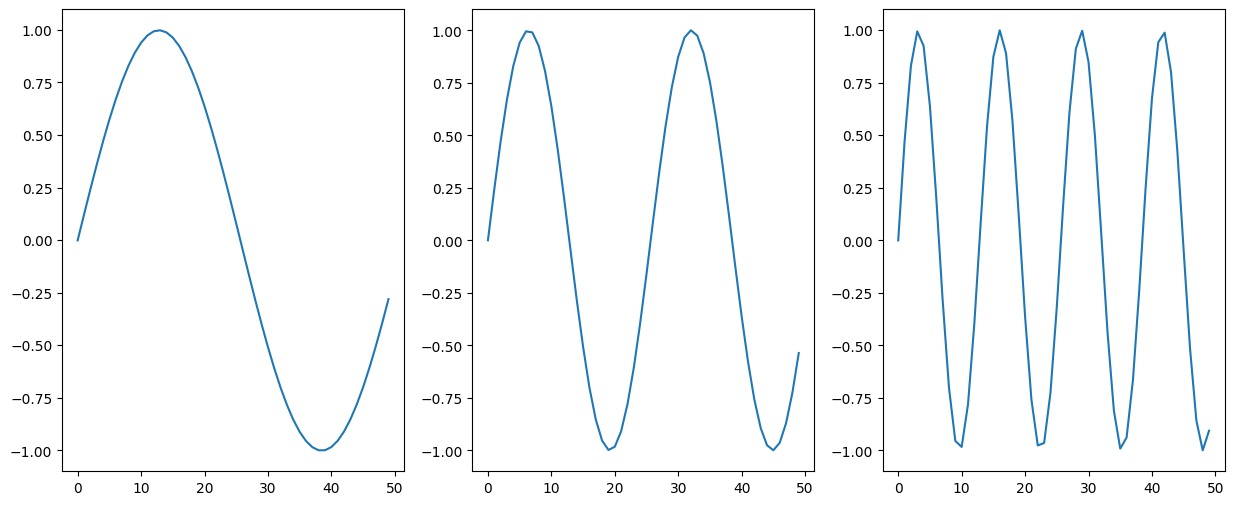

In [122]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 6))
x = np.linspace(0, 6)

ax[0].plot(dynamics[0](x))

ax[1].plot(dynamics[1](x))

ax[2].plot(dynamics[2](x))


In [123]:
bandwidth = 1
reg = 1e-7

In [124]:
fits = []
for d in datasets:
    model = KernelRidgeRegression(
        kernels=[GaussianKernel(bandwidth=bandwidth)],
        reg = reg
    )

    model.fit(d.data)
    fits.append(model)


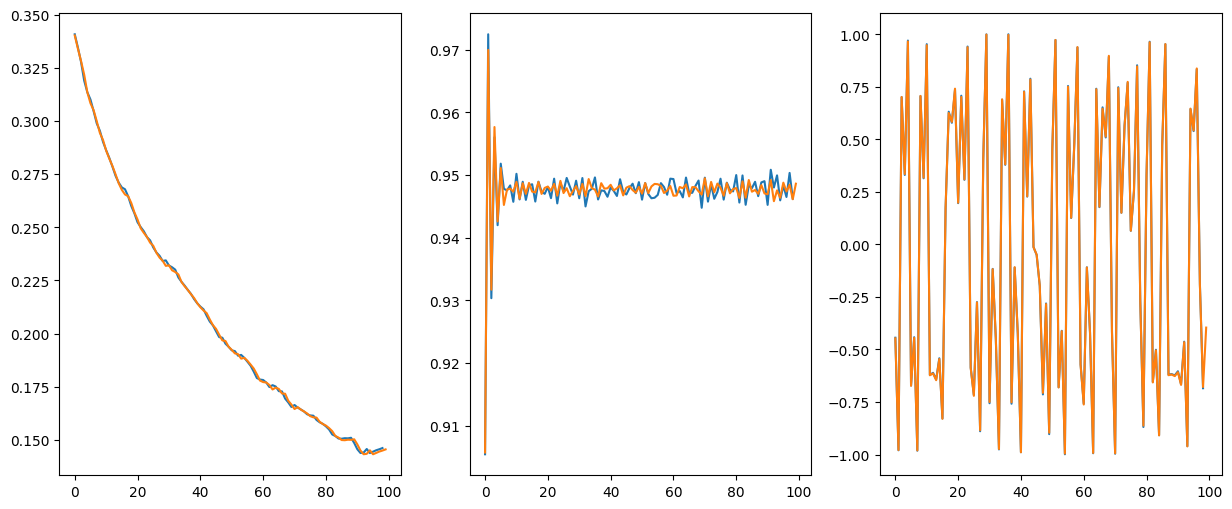

In [125]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 6))

ax[0].plot(datasets[0].data[1:])
ax[0].plot(fits[0].predict(datasets[0].data))

ax[1].plot(datasets[n_sets].data[1:])
ax[1].plot(fits[n_sets].predict(datasets[10].data))

ax[2].plot(datasets[2*n_sets].data[1:])
ax[2].plot(fits[2*n_sets].predict(datasets[20].data))

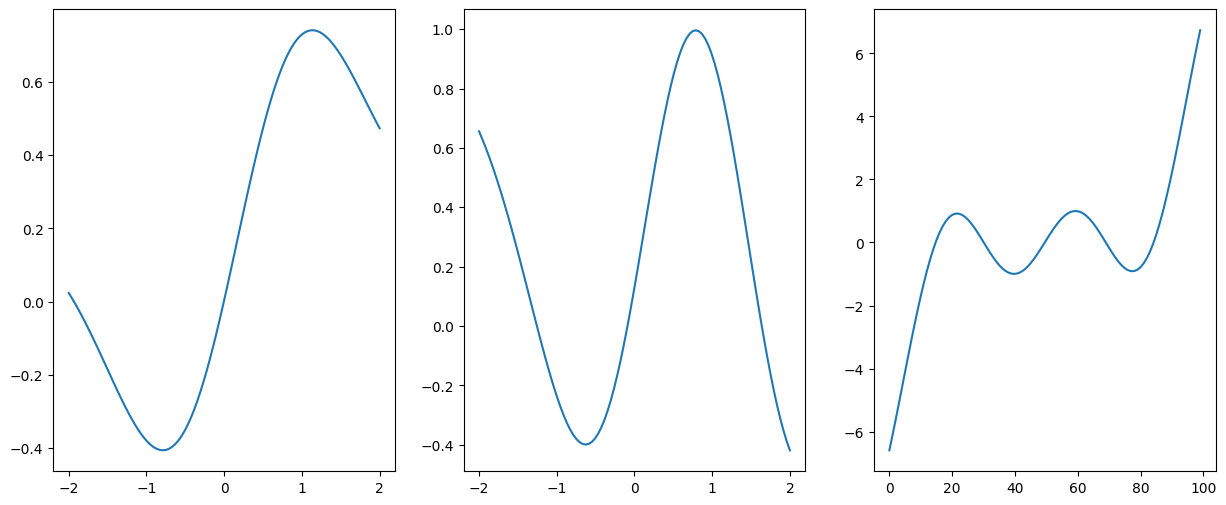

In [126]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 6))

x = np.linspace(-2, 2, 100)

ax[0].plot(x, fits[0].predict(x))

ax[1].plot(x, fits[n_sets].predict(x))

ax[2].plot(fits[2*n_sets].predict(x))

In [127]:
# Clustering
distance_matrix = np.zeros((len(datasets), len(datasets)))

kernel = GaussianKernel(bandwidth=bandwidth)

for i in range(len(datasets)):
    dii = (fits[i].alpha.T@kernel(datasets[i].data[:-1], datasets[i].data[:-1])@fits[i].alpha)[0][0]
    for j in range(i, len(datasets)):
        djj = (fits[j].alpha.T@kernel(datasets[j].data[:-1], datasets[j].data[:-1])@fits[j].alpha)[0][0]

        dij = (fits[i].alpha.T@kernel(datasets[i].data[:-1], datasets[j].data[:-1])@fits[j].alpha)[0][0]

        # distance_matrix[i][j] = dii + djj - 2*dij
        distance_matrix[i][j] = 2 - 2*dij/np.sqrt(dii * djj)
        distance_matrix[j][i] = distance_matrix[i][j]

In [128]:
distance_matrix = distance_matrix/distance_matrix.max()

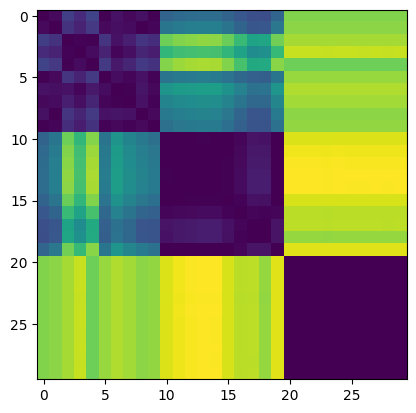

In [129]:
plt.imshow(distance_matrix)

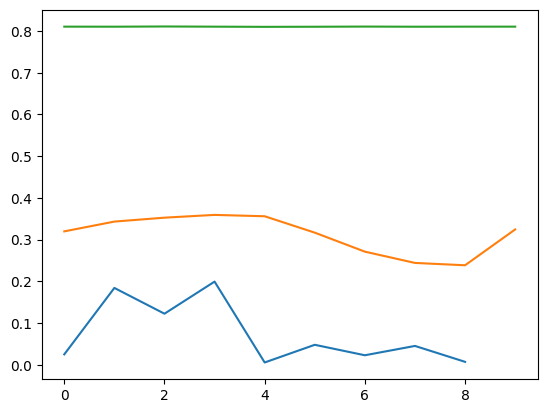

In [130]:
plt.plot(distance_matrix[0, 1:n_sets]);
plt.plot(distance_matrix[0, n_sets:2*n_sets]);
plt.plot(distance_matrix[0, 2*n_sets:]);

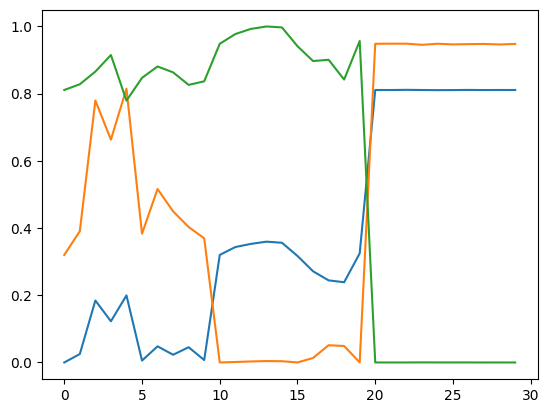

In [131]:
plt.plot(distance_matrix[0, :])
plt.plot(distance_matrix[n_sets, :])
plt.plot(distance_matrix[2*n_sets, :])

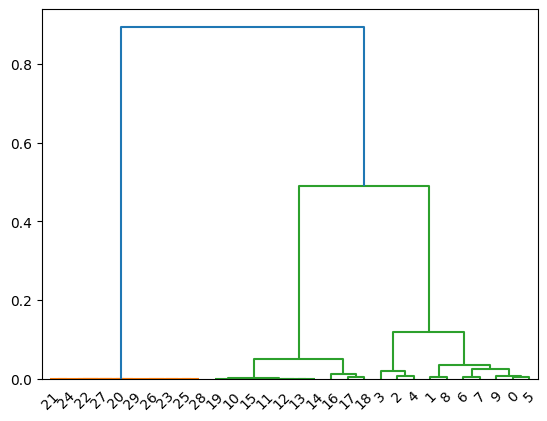

3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [132]:
# Assuming D is your full distance matrix
condensed_D = squareform(distance_matrix)  # if D is a full matrix
Z = linkage(condensed_D, method='average')
plt.figure()
dendrogram(Z)
plt.show()

# Get cluster labels
labels = fcluster(Z, t=3, criterion='maxclust')  # t is number of clusters
cluster_labels = pd.Series(labels)

for c in cluster_labels.unique():
    cluster_indices = cluster_labels[cluster_labels == c].index
    cluster_truth_labels = [datasets[i].label for i in cluster_indices]

    print(f"{c}: {cluster_truth_labels}")

In [133]:
rand_score(
    labels_true=[d.label for d in datasets],
    labels_pred=labels
)

1.0

In [134]:
adjusted_rand_score(
    labels_true=[d.label for d in datasets],
    labels_pred=labels
)

1.0

# All together


In [212]:
epsilon = 1e-3
n_sets = 10

bandwidth = 1.5
reg = 1e-9

n_dynamics = 3

In [240]:
def sin_func(i):
    return lambda x: np.sin(i*x) + epsilon*np.random.normal(0, 1)

dynamics = []

for i in range(n_dynamics+1):
    dynamics.append(sin_func(i))

# Dataset generation
datasets = []

for d_id, fd in enumerate(dynamics):
    for i in range(n_sets):
        x0 = np.random.random()
        datasets.append(
            Dataset(
                generate_time_series(x0, fd, 200),
                d_id
            )
        )

# Fitting
fits = []
for d in datasets:
    model = KernelRidgeRegression(
        kernels=[GaussianKernel(bandwidth=bandwidth)],
        reg = reg
    )

    model.fit(d.data)
    fits.append(model)


# Clustering
distance_matrix = np.zeros((len(datasets), len(datasets)))

kernel = GaussianKernel(bandwidth=bandwidth)

for i in range(len(datasets)):
    dii = (fits[i].alpha.T@kernel(datasets[i].data[:-1], datasets[i].data[:-1])@fits[i].alpha)[0][0]
    for j in range(i, len(datasets)):
        djj = (fits[j].alpha.T@kernel(datasets[j].data[:-1], datasets[j].data[:-1])@fits[j].alpha)[0][0]

        dij = (fits[i].alpha.T@kernel(datasets[i].data[:-1], datasets[j].data[:-1])@fits[j].alpha)[0][0]

        # distance_matrix[i][j] = dii + djj - 2*dij
        distance_matrix[i][j] = 2 - 2*dij/np.sqrt(dii * djj)
        distance_matrix[j][i] = distance_matrix[i][j]

# Assuming D is your full distance matrix
condensed_D = squareform(distance_matrix)  # if D is a full matrix
Z = linkage(condensed_D, method='average')
labels = fcluster(Z, t=n_dynamics, criterion='maxclust')  # t is number of clusters

adjusted_rand_score(
    labels_true=[d.label for d in datasets],
    labels_pred=labels
)

0.36202735317779566

In [241]:
cluster_labels = pd.Series(labels)

for c in cluster_labels.unique():
    cluster_indices = cluster_labels[cluster_labels == c].index
    cluster_truth_labels = [datasets[i].label for i in cluster_indices]

    print(f"{c}: {cluster_truth_labels}")

3: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
1: [0, 0, 0, 0]
2: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [138]:
labels_true=np.array([d.label for d in datasets])

In [139]:
labels_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

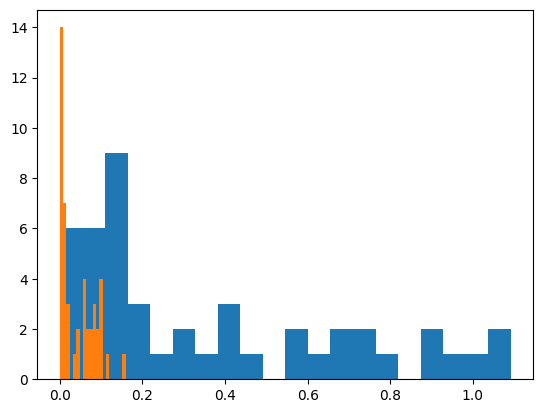

In [190]:
d1 = np.unique(distance_matrix[labels_true == 0, :][:, labels_true == 0])
d2 = np.unique(distance_matrix[labels_true == 1, :][:, labels_true == 1])
d3 = np.unique(distance_matrix[labels_true == 2, :][:, labels_true == 2])

plt.hist(d1, bins=20);
plt.hist(d2, bins=20);
plt.hist(d3, bins=20);

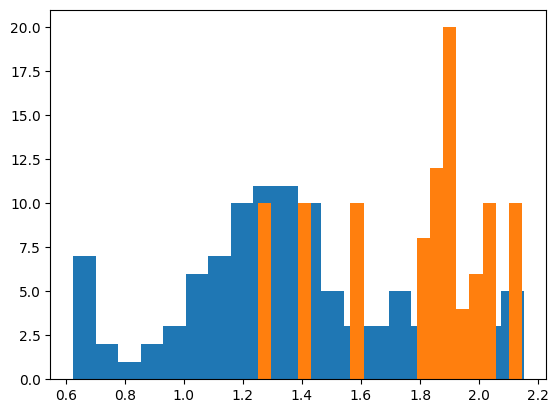

In [198]:
d12 = np.unique(distance_matrix[labels_true == 0, :][:, labels_true == 1])
d13 = np.unique(distance_matrix[labels_true == 0, :][:, labels_true == 2])

plt.hist(d12, bins=20);
plt.hist(d13, bins=20);

In [192]:
def unique(lst):
    result = []
    for element in lst:
        if element not in result:
            result.append(element)
    return result

In [193]:
indices = np.arange(len(datasets))
clusters = []
for i in indices:
    cluster = [i]
    dist = distance_matrix[i, :]
    # First nearest
    idx_1 = np.where(dist == dist[dist > 0].min())[0][0]
    val_1 = dist[idx_1]
    cluster.append(idx_1)

    clusters.append(sorted(cluster))

clusters = unique(clusters)

In [194]:
cluster_distances = np.zeros((len(clusters), len(clusters)))

for i in range(len(clusters)):
    for j in range(i, len(clusters)):
        for e1 in clusters[i]:
            for e2 in clusters[j]:
                cluster_distances[i, j] += distance_matrix[e1, e2]
        cluster_distances[i, j] /= len(clusters[i])*len(clusters[j]) # Avergae distance between all points between clusters
        

In [195]:
cluster_distances[1, :]

array([0.        , 0.0260958 , 0.05303923, 0.05592365, 0.12012556,
       0.10262984, 0.0738662 , 1.20390086, 0.9747607 , 1.10653725,
       1.205967  , 1.07531977, 1.0980822 , 1.03507542, 1.86031362,
       1.86105464, 1.85250549, 1.85170884, 1.85301051, 1.85552511,
       1.8589481 , 1.85700606])

In [196]:
intracluster_distances = []
for c in clusters:
    d = 0
    for i in c:
        for j in c:
            d += distance_matrix[i, j]
    d /= len(c)**2

    intracluster_distances.append(d)

In [197]:
intracluster_distances

[np.float64(0.028980847049714376),
 np.float64(0.026095804398489908),
 np.float64(0.01778817765860463),
 np.float64(0.014876197609170916),
 np.float64(0.005337493491584189),
 np.float64(0.056021464385726305),
 np.float64(0.04205189427699174),
 np.float64(3.86375413908846e-05),
 np.float64(0.006267180152513929),
 np.float64(0.0008028053201645236),
 np.float64(0.007519722327317124),
 np.float64(0.0006867434094144365),
 np.float64(0.0008228014805128359),
 np.float64(0.002380397734493278),
 np.float64(7.887725038469018e-05),
 np.float64(4.728599834968872e-05),
 np.float64(1.028300565075746e-05),
 np.float64(1.962829340007577e-05),
 np.float64(2.0546376472307948e-05),
 np.float64(1.0892416237195945e-05),
 np.float64(1.555343531467468e-05),
 np.float64(7.168640344390464e-05)]